# Lens Calculator for Fabry-Perot Cavity

Calulate the change in a beam of light starting at the beam waist in a Fabry-Perot cavity then going through a series of lenses

In [1]:
import numpy as np
import sympy as sym
import matplotlib as mp
import matplotlib.pyplot as plt
from sympy.physics.mechanics import init_vprinting

# plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'
init_vprinting()

## Important Functions

In [2]:
# Functions for lenses and distance
# =================================
def as_sym(x, use_sym=False):
    if use_sym == False:
        M = np.array(x)
    elif use_sym == True:
        M = sym.Matrix(x)
    else:
        M = print('Error: Please specify True or False for Sympy')
    return M

# Curved interface matrix
def interface(ni, nf, R, use_sym=False):
    A = [[1, 0], [(ni-nf)/(R*nf), ni/nf]]
    M = as_sym(A, use_sym)
    return M

# Distance matrix
def dist(d, use_sym=False):
    A = [[1, d], [0, 1]]
    M = as_sym(A, use_sym)
    return M

# Lens matrix
# Use sym.oo for flat interface
def lens(n_medium=1, n_lens=1, R_in=sym.oo, R_out=sym.oo, thickness=5, use_sym=False):
    interface_in = interface(n_medium, n_lens, R_in, use_sym)
    interface_out = interface(n_lens, n_medium, R_out, use_sym)
    lens_thickness = as_sym([[1, thickness], [0, 1]], use_sym)
    return interface_out@lens_thickness@interface_in

# Functions for the beam:
# =======================

# Waist (radius) of beam and 
# angle with respect to x-axis
def beam(waist, angle, use_sym=False):
    return as_sym([[waist], [angle]], use_sym)

# Rayleigh length
def z_Rayleigh(beam_front_curvature, dist, use_sym=False):
    if use_sym == False:
        z_R = np.sqrt(dist * (beam_front_curvature-dist))
    elif use_sym == True:
        z_R = sym.sqrt(dist * (beam_front_curvature-dist))
    else: 
        z_R = print('Error: Please specify True or False for Sympy')
    return z_R

# Beam waist size
def waist0(wavelength, z_R, use_sym=False):
    if use_sym == False:
        w_0 = np.sqrt((wavelength/sym.pi) * z_R)
    elif use_sym == True:
        w_0 = sym.sqrt((wavelength/np.pi) * z_R)
    else: 
        w_0 = print('Error: Please specify True or False for Sympy')
    return w_0

# Beam waist after certain distance z
def waistz(wavelength, z_R, z, use_sym=False):
    w_0 = waist0(wavelength, z_R, use_sym)
    if use_sym == False:
        w_z =  w_0 * np.sqrt(1 + (z/z_R)**2)
    elif use_sym == True:
        w_z =  w_0 * sym.sqrt(1 + (z/z_R)**2)
    else: 
        w_z = print('Error: Please specify True or False for Sympy') 
    return w_z

# Complex beam parameter
def q_CBP(dist, z_R):
    return dist + z_R*1j

# The angle the beam makes with the 
# mirror of the Fabry-Perot cavity
def Theta0(wavelength, mirror_curvature, mirror_focal, lens_pos, use_sym=False):
    # We want the radius of curvature of the beam front to match
    # the radius of curvature of the mirror when it hits the 
    # mirror after originating from the focal length of the mirror
    z_r = z_Rayleigh(mirror_curvature, mirror_focal, use_sym)
    w_z = waistz(wavelength, z_r, mirror_focal, use_sym)
    theta = w_z/lens_pos
    return theta

## Symbols

In [3]:
# Beam waists
w0, wf = sym.symbols('w_0 w_f', real=True)

# Beam angle (small angles)
theta0, thetaf = sym.symbols('theta_0 theta_f', real=True)

# Complex beam parameters
q0, qf = sym.symbols('q_0 q_f')

# Distances
# For lens thickness
d0, d1, d2, d3, d4 = sym.symbols('d:5', real=True)
# For distance between lens
x0, x1, x2, x3, x4 = sym.symbols('x:5')

# Indicies of refraction
nl, nm = sym.symbols('n_l n_m', real=True)

# Radius of curvature for lens
r00, r01, r10, r11, r20, r21 = sym.symbols('r_{00} r_{01} r_{10} r_{11} r_{20} r_{21}')

## Matricies for beam, lenses, and distances

In [4]:
beam0 = beam(w0, theta0, use_sym=True)
beamf = beam(wf, thetaf, use_sym=True)

dist0 = dist(x0, use_sym=True)
lens0 = lens(nm, nl, r00, sym.oo, d0, use_sym=True)
dist1 = dist(x1, use_sym=True)
lens1 = lens(nm, nl, r10, sym.oo, d1, use_sym=True)
dist2 = dist(x2, use_sym=True)
lens2 = lens(nm, nl, r20, sym.oo, d2, use_sym=True)

## Commence calculation using matricies

In [ ]:
Final = (lens2@dist2@lens1@dist1@lens0@dist0@beam0).applyfunc(sym.simplify)

# display(Final)

In [ ]:
# Sub in the stuff we know
# Lengths in units of mm
Final_sub1 = Final.subs({nm:1, nl:1.515, r00:50, 
                         x0:25, d0:3, 
                         w0:0,
                         theta0:Theta0(780e-6, 2*25, 25, 25, use_sym=True)
                        }).applyfunc(sym.simplify)
# display(Final_sub1)

In [ ]:
# Sub in the radius of curvatures
# for the lens we want to use 
Final_sub2 = Final_sub1.subs({r10:-100, r20:-200, d1:5.3, d2:3.6,}).applyfunc(sym.simplify)
# display(Final_sub2)

In [ ]:
sym.solvers.solve(Final_sub2 - beamf.subs({wf:1.12, thetaf:0}), (x1, x2))

## Calculation using complex beam parameter

In [ ]:
beamq0 = beam(q0, 1, use_sym=True)
beamqf = beam(qf, 1, use_sym=True)

In [ ]:
Finalq = (lens2@dist2@lens1@dist1@lens0@dist0@beamq0).applyfunc(sym.simplify)

Finalq_sub1 = Finalq.subs({nm:1, nl:1.515, 
                           r00:-50, 
                           r01:sym.oo, r11:sym.oo, r21:sym.oo,
                           x0:25, d0:6, d1:5.3, d2:3.6
                         }).applyfunc(sym.simplify)

Finalq_sub2 = Finalq_sub1.subs({r10:50*2, r20:200*2}).applyfunc(sym.simplify)

In [ ]:
k = sym.pi / 780e-6
Qf = 1j * k * (1.25/7)**2
Q0 = 1j * k * (25*np.pi*10e-3)**2

Finalq_sub3 = Finalq_sub2.subs({q0:Q0})
Beamqf_sub = beamqf.subs({qf:Qf})

solution = sym.solvers.solve(Finalq_sub3[0]/Finalq_sub3[1] - Beamqf_sub[0], (x1, x2))
display(solution)

In [ ]:
X2 = sym.solvers.solve(solution[0][0], x2)
X1 = solution[0][0].subs({x2: X2[0]}).simplify()
display(X1, X2[0])

## Ray tracing

In [ ]:
# lens(1, 1.515, np.inf, -50, 7.5) @ dist(30) @ lens(1, 1.515, np.inf, 100, 5) @ dist(70) @ lens(1, 1.515, np.inf, 200, 5)
@np.vectorize
def beam_prop_cavity(x, wavelength=780e-7, w0=0.5):
    q1 = 1/(- 1j * wavelength / (np.pi * w0**2))
    T = lens(1, 1.515, np.inf, 50, 3) @ dist(59) @ lens(1, 1.515, np.inf, -100, 5.3) @ dist(250) @ lens(1, 1.515, np.inf, -400, 3.6)
    A = dist(x) @ T @ beam(q1, 1)
    qf = A[0]/A[1]
    wf = np.sqrt(-wavelength / (np.pi * np.imag(1/qf)))
    return wf, 1/np.real(1/qf)

In [ ]:
x = np.linspace(0, 50, 400)
# T = lens(1, 1.515, np.inf, 200, 5) @ dist(110) @ lens(1, 1.515, np.inf, 100, 5)
for n in range(60, 63, 1):
    plt.plot(x, beam_prop_cavity(x, w0=2.5/(2*(6+n/100)))[1], label='n={0}'.format(n))
# plt.plot(x, beam_prop_cavity(x, w0=0.001))

# plt.ylim(bottom=0)
plt.xlabel('Distance (mm)')
plt.ylabel('Beam waist (mm)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
25*np.pi

In [ ]:
beam_prop_cavity(50, w0=2.5/(2*(6+61/100)))[1]

## Attempt \#3

In [35]:
lam = 780e-6
w_l = 1

T = lens2@dist2@lens1@dist1@lens0
beamq01 = beam(q0, 1, use_sym=True).subs({q0: d0 - 1j*d0*(d0-50)})
beamqf1 = beam(qf, 1, use_sym=True).subs({qf: 1j*sym.pi*wf**2 / lam})

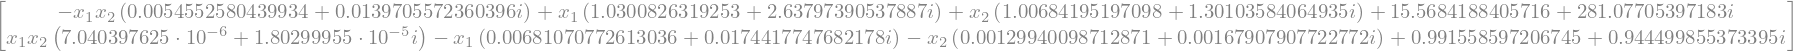

In [8]:
a = (T@beamq0).applyfunc(sym.simplify)
a_sub1 = a.subs({nm:1, nl:1.515, 
                 r00:-50, r01:sym.oo, 
                 r10:100, r11:sym.oo, 
                 r20:400, r21:sym.oo,
                 x0:25, d0:6, d1:5.3, d2:2.8
                }).applyfunc(sym.simplify)
display(a_sub1)

In [40]:
sol = sym.solvers.solve(a_sub1[0]/a_sub1[1] - beamqf1[0], wf)

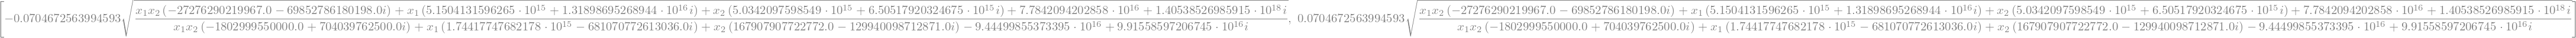

In [51]:
display(sol)

In [ ]:
display([sol[0][0].simplify(), sol[0][1]])

## Attempt ray tracing towards laser

In [58]:
@np.vectorize
def beam_prop_laser(x, d0, wavelength=780e-7):
    q1 = 1/(- 1j * wavelength / (np.pi * w0**2))
    T = lens(1, 1.515, 100, np.inf, 5.3) @ dist(250) @ lens(1, 1.515, 400, np.inf, 3.6) @ dist(50) @ lens(1, 1.515, np.inf, 50, 3)
    A = dist(x) @ T @ beam(d0-1j*d0*(d0-50), 1)
    qf = A[0]/A[1]
    wf = np.sqrt(-wavelength / (np.pi * np.imag(1/qf)))
    return wf, 1/np.real(1/qf)

In [61]:
x = np.arange(0, 100, 1)

for d0 in range(0, 10, 1):
    plt.plot(x, beam_prop_laser(x, d0)[0], label='{0}'.format(d0))
plt.legend()

/Users/kev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


<Figure size 432x288 with 1 Axes>